# Computer Lab: Nonnegative Matrix Factorization
# SD-TSIA 211
## Davi Barreto Façanha and Thiago Azevedo Campos Costa
## 13/12/2019


##### Import:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.sparse
import scipy.sparse.linalg
import time

In [2]:
# Change the default settings for plotting size

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

##### Useful functions:

In [3]:
def build_matrix_from_faces(folder='orl_faces', minidata=False):
    # load images
    # 400 images of size (112, 92)
    M = []
    if minidata is True:
        nb_subjects = 1
    else:
        nb_subjects = 40
    for subject in range(1, nb_subjects + 1):
        for image in range(1, 11):
            face = plt.imread(folder + '/s' + str(subject) + '/' + str(image) + '.pgm')
            M.append(face.ravel())

    return np.array(M, dtype=float)

def vectorize(W, H):
    return np.concatenate((W.ravel(), H.ravel()))

def unvectorize_M(W_H, M):
    # number of elements in W_H is (n+p)*k where M is of size n x m
    # W has the nk first elements
    # H has the kp last elements
    n, p = M.shape
    k = W_H.shape[0] // (n + p)
    W = W_H[:n * k].reshape((n, k))
    H = W_H[n * k:].reshape((k, p))
    return W, H

### Question 1.1
The database "orl_faces" by AT&T Laboratories Cambridge was succesfully downloaded and extracted. It's possible to now create a matrix M to represent the images. A few tests may be done with the data as follows, such as, for exemple, showing a few faces.

In [4]:
# Small data to test the algorithm (10 faces of 1 subject)
M = build_matrix_from_faces(folder='orl_faces', minidata=True)
def unvectorize(W_H): return unvectorize_M(W_H, M)

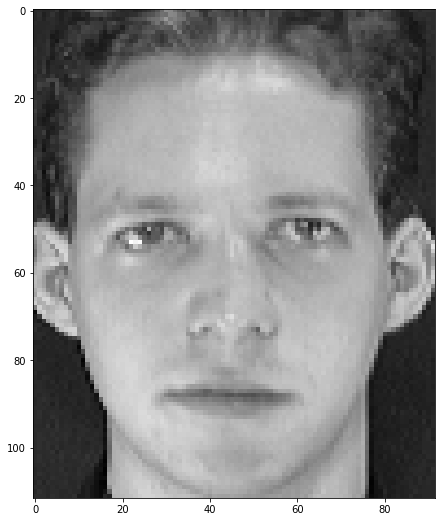

In [5]:
# To see the first face:
plt.imshow(M[0].reshape((112, 92)), cmap='gray'); plt.show()

In [6]:
# Full data (10 faces from 40 subjects)
M = build_matrix_from_faces(folder='orl_faces', minidata=False)
def unvectorize(W_H): return unvectorize_M(W_H, M)

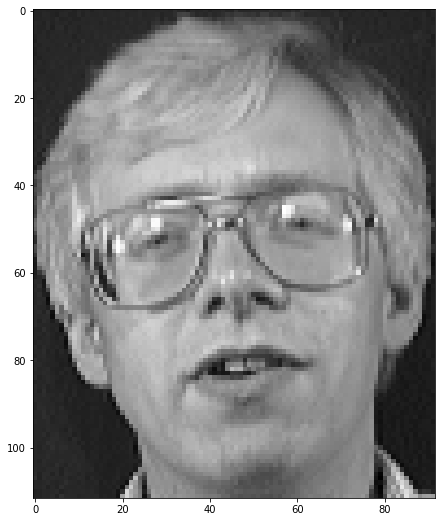

In [7]:
# To see the first face of the second subject:
plt.imshow(M[10].reshape((112,92)), cmap='gray'); plt.show()

### Question 2.1

In [8]:
# To get the number of images
n = len(M)

# To get the number of pixels per image
p = len(M[0])

In [9]:
print('Number of images (n):', n)
print('Number of pixels in each image (p):', p)

Number of images (n): 400
Number of pixels in each image (p): 10304


#### Discussion:
So there are 400 images in the database and each imagem has 10304 pixels (rearrenged in 112 x 92 in order to be an image). That means we have a matrix $M$ containing 400 rows and 10304 columns.

### Question 3.1
**Show with a 1D example that the objective function is not convex.**

The model we want to train has the following objective function:

$$f(W,H) = \frac{1}{2np}||M - WH||^2_F$$

For a 1D example, we can choose our matrices as 1x1 dimension. Therefore, we can treat our objective function as a scalar function.

$$f(w,h) = \frac{1}{2np}(m-wh)^{2}$$

To know if we are dealing with a convex function or not, we need to calculate the Hessian Matrix of the Function. The differentiable function is convex i.i.f the *Hessian* $\triangledown^{2}f(w)$ is positive semi-definite for all $w_{ij} \in RxR$. Thus, beeing the determinant equals to the product of the eigenvalues, if it is positive, we have a convex function.

|                                                 	|                                                                	|
|:-----------------------------------------------:	|:--------------------------------------------------------------:	|
| $$\frac{df}{dw} = (m-wh)(-h)$$                  	| $$\frac{df}{dh} = (m-wh)(-w)$$                                 	|
| $$\frac{\partial^{2} f}{\partial^{2} w} = h^2$$ 	| $$\frac{\partial^{2} f}{\partial^{2} w \partial h} = 2hw - m$$ 	|
| $$\frac{\partial^{2} f}{\partial^{2} h} = w^2$$ 	| $$\frac{\partial^{2} f}{\partial^{2} h \partial w} = 2hw - m$$ 	|


So, we find the following Hessian Matrix:

$$ H(f) = 
\begin{bmatrix}
h^2 &  2hw - m\\ 
2hw - m &  w^2
\end{bmatrix}$$

And finally,

$$Det(H) = -3\cdot(w^2)\cdot(h^2) + 4\cdot whm - m^2$$

There are several possibles counter-examples in order to proof the non convexity of the function. If we set $w=2$, $h=1$ and $m=7$, for example, we find a negative determinant. 

**Ergo, the function is not convex**.


### Question 3.2

**Calculate the gradient of the objective function.**

We need to compute the gradient of the objective function, knowing that:

$$||M - WH||^2_F = tr((M - WH)^T(M - WH)) = tr(M^TM - M^TWH - W^TH^TM + W^TH^TWH)$$

As the trace is a linear operator, we can compute the derivatives as:

$$\nabla_Atr(AB) = B^T$$

Given that, the gradient of $f(W,H)$ is:

$$\nabla f(W,H) = \begin{pmatrix} \nabla_W f(W,H) \\ \nabla_H f(W,H) \end{pmatrix}$$

$$\nabla f(W,H) = \begin{pmatrix} \frac{1}{np}(WH - M)H^T \\ \frac{1}{np}W^T(WH - M) \end{pmatrix}$$

### Question 4.1

**What is the advantage of this choice? What would be other possibilities for the initialization?**

In [10]:
# The K value necessary for the Singular Value Decomposition 
k = 38

# Singular Value Decomposition to initiate the algorithm
W0, S, H0 = scipy.sparse.linalg.svds(M, k)
W0 = np.maximum(0, W0 * np.sqrt(S))
H0 = np.maximum(0,(H0.T * np.sqrt(S)).T)

### a) What is the advantage of this choice?

The **Singular Value Decomposition**, or SDV, is the method used to initialize the algorithm.
It consists as a generalization of the **Eingendecomposition**, where we decompose the Matrix M into a **Left-Side** and a **Right-Side Single-Values Matrix**. The S Matrix is a diagonal matrix with **non-negative real numbers**.

$$ M = W_{0}SH_{0} $$

With that, we can find an $H_{0}$ to decompose our matrix. Fixing it at the first iteration, we have now only a function of W. Therefore, our objective function,

$$(\hat{W}, \hat{H}) \in arg \underset{W \geq 0, H \geq 0}{min} \frac{1}{2np}||M-WH||_{F}^{2}$$

turns into,

$$ W^{-1} \in arg \underset{W \geq 0}{min} g(W) \quad where, \quad g(W) = \frac{1}{2np}||M - WH_{0}||_{F}^{2}$$

The choice of SDV is a great choice not only because it is a complex method that analyzes the geometric structure of the matrix, but also because from the decomposition as a function of eigenvectors, we can factorize our matrix into smaller dimensions matrices, making it computationally easier to work.

### b) What would be other possibilities for the initialization?

A method very known as well for matrix factorization is the **LU Decomposition**. However, in our case, it would be necessary to apply a little variation of the usual LU method, using an extra matrix in the process, a Permutation Matrix.

By the **Gauss-Elimination** step-by-step, we find our Upper Matrix:

\begin{matrix}
\begin{pmatrix}
1 & 5 & 1 & -2\\ 
14& 6 & 2 & 7\\ 
6 & 0 & 14 & 0 
\end{pmatrix} 
& 
\overset{E_1}{\underset{R_2-14\cdot R_1 \rightarrow R_2}{\rightarrow}} 
& 
\begin{pmatrix}
1 & 5 & 1 & -2\\ 
0& -64 & -12 & 35\\ 
6 & 0 & 14 & 0 
\end{pmatrix} 
& 
\overset{E_2}{\underset{R_3-6\cdot R_1 \rightarrow R_3}{\rightarrow}}
&
\begin{pmatrix}
1 & 5 & 1 & -2\\ 
0& -64 & -12 & 35\\ 
0 & -30 & 8 & 12 
\end{pmatrix} 
\end{matrix}

\begin{matrix}
\begin{pmatrix}
1 & 5 & 1 & -2\\ 
0& -64 & -12 & 35\\ 
0 & -30 & 8 & 12 
\end{pmatrix} & \overset{E_3}{\underset{R_3-0.47\cdot R_2 \rightarrow R_3}{\rightarrow}} & 
\begin{pmatrix}
1 & 5 & 1 & -2\\ 
0& -64 & -12 & 35\\ 
0 & 0 & 13.63 & -4.41 
\end{pmatrix} & = U
\end{matrix}

We have $U =E_3 E_2 E_1 A $, than $A =E_1^{-1}E_2^{-1}E_3^{-1} U $. Furthermore, we can calculate the PL Matrix applying each Gaussian Step ($E_i^{-1}$) on a Identity Matrix. The result of this is a matrix equivalent of a Permutation Matrix times a Lower Matrix.

Finally, we have decomposed our A matrix into $PL\cdot U$.

However, we need to make the projection onto $\mathbb{R}_{+}$. For this we can just define a function as in **Question 4.4** and apply it to each Matrix value. Like this, we ensure that, at the end, our decomposition is a Non-Negative one.

### Question 4.2

**Is the objective function g convex? Calculate its gradient. We will admit that the gradient of g is Lipschitz continuous with constant $L_0 = \frac{||(H_0)^T H_0||}{np}$ .**

We have the following objective function:

$$g(W) = \frac{1}{2np}||M - WH_0||^2_F$$

In a simillar way as did before in 3.2, we can calculate the gradient of the function, that will have only one dimension (is only function of W).

$$\nabla_W g(W) = \frac{1}{np}(WH_0-M)H_0^T$$

In order to show if the $g()$ function is convex, we can assume that:

$$g \ is \ convex \iff \nabla^2g \ positive \ semidefinite$$


We can compute the Hessian matrix of g, which in this case is:

$$\nabla^2 g(W) = \nabla_W(\nabla_Wg(W))$$

Thus:

$$\nabla^2 g(W) = \frac{1}{np}H_0^TH_0$$

By definition, the $H_0$ is always positive semidefinite. So the Hessian matrix is always positive semidefinite and the function is convex.

### Question 4.3

**Write a function to compute $g(W)$ and another to compute $\nabla W$.**

In [11]:
# Calculate the g() function.
def g(W = W0, H = H0, M = M):
    return((np.linalg.norm(M - np.dot(W, H))**2) / (len(M) * len(M[0]) * 2))

# Calculate the Gradient for each case below
def grad_g(W = W0, H = H0, mode = 0, M = M):
    # Grad_g(W)
    if(mode == 0):
        return(np.dot(np.dot(W,H) - M, H.T) / (len(M) * len(M[0])))
    
    # Grad_g(H)
    if(mode == 1):
        return(np.dot(W.T, np.dot(W,H) - M) / (len(M) * len(M[0])))
    
    # Grad_g(W,H)
    if(mode == 2):
        grad_w = np.dot(np.dot(W,H) - M, H.T) / (len(M) * len(M[0]))
        grad_h = np.dot(W.T, np.dot(W,H) - M) / (len(M) * len(M[0]))
        return(np.array([grad_w, grad_h]))
    
    return(0)

### Question 4.4

**Show that for all $\gamma>0$, $prox_{\gamma l \mathbb{R}_{+}}$ is the projection onto $\mathbb{R}_{+}$.**

At first, we have the following definition:

$$l_{\mathbb{R}_{+}} : \mathbb{R} \rightarrow \mathbb{R} \; \cup \; \{+ \infty\}$$

$$ \left\{\begin{matrix}
0 \quad if x \geq 0
\\ 
+\infty \quad if x < 0
\end{matrix}\right. $$

Applying on the Proximal Definition, we have:

$$prox_{\gamma l_{\mathbb{R}_{+}}}(x) = arg \underset{y \in \mathbb{R}_{+}}{min}( l_{\mathbb{R}_{+}}(y) + \frac{1}{2\gamma}||y-x||^2 )$$

When $x \geq 0$, the proximal equation becomes only the right argument:

$$prox_{\gamma l_{\mathbb{R}_{+}}}(x) = arg \underset{y \in \mathbb{R}_{+}}{min}( \frac{1}{2\gamma}||y-x||^2 )$$

Thus, $prox_{\gamma l_{\mathbb{R}_{+}}}(x) = x$

On the other hand, if $x < 0$, the minimum value of $y$ we can get so that the function does not go to infinity is $y=0$. 

Therefore, $prox_{\gamma l_{\mathbb{R}_{+}}}(x) = 0$

Finally, we can observe that regardless of the $\gamma$ value, with $\gamma > 0$, our function is part of the projection onto $\mathbb{R}_{+}$.

$\blacksquare$

### Question 4.5

**Code a function $projected \; gradient \; method(val \; g, grad \; g, W0, gamma, N)$ that minimizes a function g subject to nonnegativity constraints by the projected gradient method with a constant step size $\gamma$, starting from $W_0$ and stopping after $N$ iterations.**

Knowing the result of Question 4.4, we have that the function $prox_{\gamma \mathbb{1} \mathbb{R}_+}$ is the projection onto $\mathbb{R}_+$.

So, given that we can apply the Projected Gradient Method, which is a method of Gradient Descent applied for constrained problems.

$$W_{k+1} = prox_{\gamma ι \mathbb{R}_+}(W_k - \gamma \nabla g(W_k))$$

In [12]:
def projected_gradient(W0_, gamma, N):
    g_ = []
    for i in range(N):
        W0_ = np.maximum(0, W0_ - gamma * grad_g(W0_))
        g_.append(g(W0_))
    return(W0_, g_)

### Question 4.6

**Use the function to minimize g with $N = 100$ and $k = 38$.**

We admit the Gradient of g is Lipschitz continuous. Therefore, by definition, we have:
$$L_0 = \frac{||(H_0)^{T}H_0||_{F}}{np}$$

As well as a constant step size:
$$\gamma_k = \frac{1}{L_0}$$

In [13]:
# Number of iterations
N = 100

# Lipschitz Constant
L0 = np.linalg.norm(np.dot(H0.T, H0)) / (n * p)

# Step Size: Gamma
gamma = 1 / L0

# Projection Gradient Method from Q.4.5
t_aux = time.time()
W, g_1 = projected_gradient(W0, gamma, N)
t_1 = time.time() - t_aux

In [14]:
print('Gamma = ', gamma)
print('g(W0) =', g(W0))
print('g(W) =', g(W))
print('Time spent:', t_1, 's')

Gamma =  14.24236591822916
g(W0) = 867.6350229602598
g(W) = 491.00633149927046
Time spent: 19.479511260986328 s


As seen above, the function $g(W)$ was well minimized in comparison with $g(W_0)$, where $W_0$ is the initialized value of W.

$$g(W_0) = 867.63$$

$$g(W) = 491.01$$

### Question 5.1

**Implement a line search to the projected gradient method, in order to free ourselves from
the need of a known Lipschitz constant.**

For minimizing the problem, we have chosen the most general Line Search Method, the **Armijo's Line Search**: 

$$ f(g^{+}(ba^l)) \; \leq \; g(W) + \beta \langle \nabla g(W), g^{+}(ba^l) - W \rangle$$

Different from the Exact Line Search Method, our step size here is defined as $\gamma_k = ba^l$. Also,

$$ g^{+}(ba^l) = W - ba^l \nabla g(W)$$

Therefore, the ideia is iterating the function on $l$ until finding the **first nonnegative integer value** that satisfies the inequality.

However, the second argument can be rewriten as $\langle \nabla g(W), g^{+}(ba^l) - W \rangle = -ba^l||\nabla g(W)||^2$. Thus,

$$ f(g^{+}(ba^l)) \; \leq \; g(W) - \beta ba^l||\nabla g(W)||^2$$

Where $a,\beta \in (0,1)$ and $b>0$.

In our case, we have used $a = 0.6$, $b=2 \cdot \gamma_{k-1}$ and $\beta = 0.8$.

In [15]:
# Armijo linesearch for W
def armijo_line_search(W, gamma = 0.4, a = 0.6, beta = 0.8):
    b = 2 * gamma
    l = 1
    while(1):
        W_plus = W - (b * (a**l) * grad_g(W))
        expression = g(W) - beta * (b * (a**l)) * (np.linalg.norm(grad_g(W))**2)
        
        if(g(W_plus) <= expression):
            return(b * (a**l))
        else:
            l += 1
            
# Armijo linesearch for H
def armijo_line_search2(H, gamma = 0.4, a = 0.6, beta = 0.8):
    b = 2 * gamma
    l = 1
    while(1):
        H_plus = H - (b * (a**l) * grad_g(H = H, mode = 1))
        expression = g(H = H) - beta * (b * (a**l)) * (np.linalg.norm(grad_g(H = H, mode = 1))**2)
        
        if(g(H = H_plus) <= expression):
            return(b * (a**l))
        else:
            l += 1

In [16]:
def projected_grad_ls(W, N):
    gamma_ = 0.4
    g_ = []
    for i in range(N):
        gamma_ = armijo_line_search(W, gamma_)
            
        W = np.maximum(0, W - gamma_ * grad_g(W))
        g_.append(g(W))
    return(W, g_)

In [17]:
# Run the projected_grad with linesearch and computes its time
t_aux = time.time()
W_ls, g_2 = projected_grad_ls(W0, 100)
t_2 = time.time() - t_aux

In [18]:
print("g(W0):", g(W0))
print("g(W) without linesearch:", g(W))
print("g(W) with linesearch:", g(W_ls))
print("Time spent:", t_2, "s")

g(W0): 867.6350229602598
g(W) without linesearch: 491.00633149927046
g(W) with linesearch: 485.724808355
Time spent: 71.9922080039978 s


### Question 5.2
#### Compare the performance of both algorithms.

Because of the linesearch process, naturally this approach will demand more time than the first one.

$$t_{L-constant} = 19.48 s$$
$$t_{linesearch} = 71.99 s$$

Also, it's possible to see in the plot below that the Method with L-constant is more smooth reaching the convergence value, which is close to the convergence value of the Method with Linesearch.

Although, the Linesearch Method has a great advantage: we don't need to know the L-constant in advance.

In [19]:
print('Time with L-constant:', t_1, 's')
print('Time with linesearch:', t_2, 's')

Time with L-constant: 19.479511260986328 s
Time with linesearch: 71.9922080039978 s


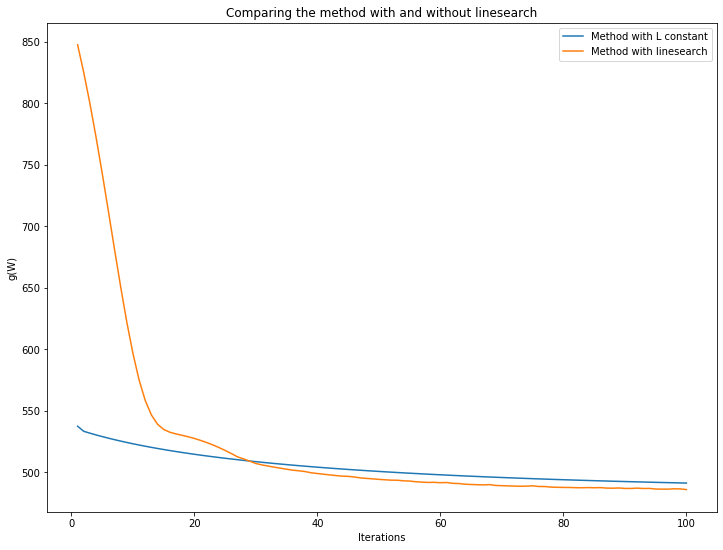

In [20]:
x = np.linspace(1, len(g_2), 100)
plt.plot(x, g_1, label = 'Method with L constant')
plt.plot(x, g_2, label = 'Method with linesearch')
plt.xlabel('Iterations')
plt.ylabel('g(W)')
plt.title('Comparing the method with and without linesearch')
plt.legend()
plt.show()

### Question 6.1
#### Solve Problem (1) by the projected gradient method with line search for N = 1000 iterations. What does the algorithm return?

We can now expand the solution already used to solve the first objective function:

$$g(W,H) = \frac{1}{2np}||M - WH||^2_F$$

But at this time, H will not be fixed. In fact, it will update at the same time as W.

The Armijo Line Search will once again be used to provide the $\gamma$ values.

In [21]:
# Armijo line search for 2 dimensions
def armijo_ls_2(W, H, gamma = 0.4, a = 0.6, beta = 0.8):
    b = 2 * gamma
    l = 1
    while(1):
        W_plus = W - (b * (a**l) * grad_g(W, H, mode = 0))
        H_plus = H - (b * (a**l) * grad_g(W, H, mode = 1))
        
        grad_W = grad_g(W = W, H = H, mode = 0)
        grad_H = grad_g(W = W, H = H, mode = 1)
        expression = g(W, H) - beta * (b * (a**l)) * (np.linalg.norm(grad_W)**2 + np.linalg.norm(grad_H)**2)

        if(g(W_plus, H_plus) <= expression):
            return(b * (a**l))
        else:
            l += 1

# Projected Gradient with Armijo line search for 2 dimensions
def grad_ls_2(W, H, N):
    gamma_ = 0.4
    g_ = []
    for i in range(N):
        gamma_ = armijo_ls_2(W, H, gamma_)
        
        W0_ = W
        H0_ = H
        
        W = W - gamma_ * grad_g(W0_, H0_, mode = 0)
        H = H - gamma_ * grad_g(W0_, H0_, mode = 1)
        
        g_.append(g(W, H))
    return(W, H, g_)

In [22]:
t_aux = time.time()
W_1, H_1, g_3 = grad_ls_2(W0, H0, 1000)
t_3 = time.time() - t_aux

In [23]:
print('g(W,H) =', g(W_1, H_1))
print('Time spent:', t_3, 's')

g(W,H) = 169.40200513729786
Time spent: 1336.0261170864105 s


As we could see from above, this approach has a significantly better result in comparison with those on 1-dimension. Altough it's easier to solve the problem with H fixed, the results are better when iterating both variables.

$$g(W,H) = 169.40$$


### Question 6.2
#### When W (resp. H) is fixed, the problem is easier to solve. The method of alternate mini-mizations uses this fact and consists in the following method:

###### for t $\ge 1$  do:

$$W_t \leftarrow arg \ min_W \frac{1}{2np}||M - WH_{t-1}||^2_F$$

$$H_t \leftarrow arg \ min_H \frac{1}{2np}||M - W_tH||^2_F$$

###### end for

#### a) Show that the value of the objective in decreasing at each iteration. 

In this method, each iteration contains an update for W and for H. But as soon as W updates, H already has its new value and can use it to compute his own.

At the beginning of an iteration, we have $W_{t-1}$ and $H_{t-1}$. As $W_t$ and $H_t$ were defined above as being argmins of the objective function, we can ensure that:

$$g(W_t, H_t) < g(W_t, H_{t-1}) < g(W_{t-1}, H_{t-1})$$

So, at the end of each iteration, we have an objective function value being **smaller** than at the beginning of the iteration, which means that the function is always **decreasing**.

#### b) Deduce from this that the value converges.

As the function is always decreasing, it's certain that it will converge to a value, knowing that the objective function $g(W,H)$ is greater or equal to zero (as it is a Squared Frobenius Norm).

Combining this two facts, we can conclude that the value **converges**.

### Question 6.3
#### Code the alternate minimizations method.

We can also implement the Alternate Method:

In [25]:
def alternate_method(W, H, N):
    gamma_ = [0.4, 0.4]
    g_ = []
    for i in range(int(N)):
        gamma_[0] = armijo_line_search(W, gamma_[0])
        W = np.maximum(0, W - gamma_[0] * grad_g(W, H, mode = 0))
        
        gamma_[1] = armijo_line_search2(H, gamma_[1])
        H = np.maximum(0, H - gamma_[1] * grad_g(W, H, mode = 1))
        
        g_.append(g(W,H))
        
    return(W, H, g_)

In [26]:
# Applying the alternate method:
t_aux = time.time()
W_2, H_2, g_4 = alternate_method(W0, H0, 1000)
t_4 = time.time() - t_aux

In [27]:
print('g(W,H) using the main method =', g(W_1, H_1))
print('g(W,H) using the alternate method =', g(W_2, H_2))
print('Time spent in alternate method:', t_4, 's')

g(W,H) using the main method = 169.40200513729786
g(W,H) using the alternate method = 211.8110156977604
Time spent in alternate method: 1669.4680881500244 s


### Question 6.4
#### Compare projected gradient and alternate minimizations methods. Are the solutions the same? Is the objective value the same? How do the computing times compare?

As we can see in the plot below, both algorithms reach similar objective values, but the Main Method reaches it with less iterations than the Alternate Method, which has a more smooth descending.

We can also see the time comparison below:

$$t_{main} = 1336.03s = 22.27 min$$
$$t_{alternate} = 1669.47s = 27.82 min$$

In [28]:
print('Time by Main Method:', t_3, 's')
print('Time by Alternate Method:', t_4, 's')

Time by Main Method: 1336.0261170864105 s
Time by Alternate Method: 1669.4680881500244 s


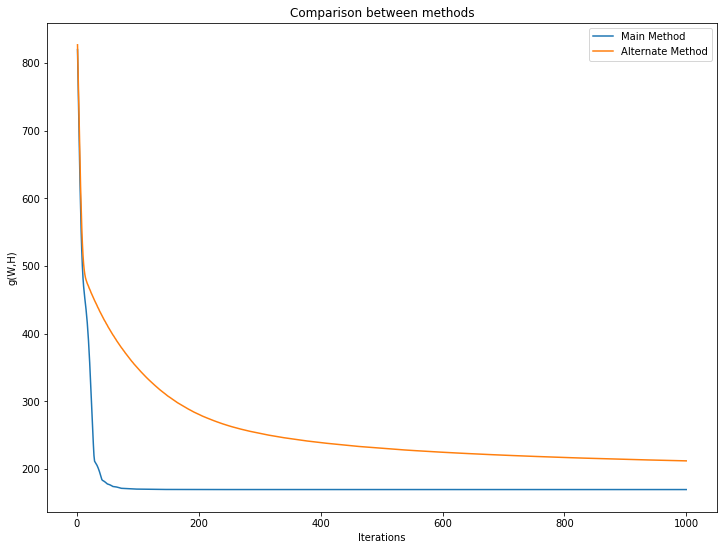

In [29]:
x = np.linspace(1, len(g_3), 1000)
plt.plot(x, g_3, label = 'Main Method')
plt.plot(x, g_4, label = 'Alternate Method')
plt.xlabel('Iterations')
plt.ylabel('g(W,H)')
plt.title('Comparison between methods')
plt.legend()
plt.show()

### Question 6.5
#### What stopping criterion could be used for the algorithms instead of just the number of iterations?

Another stopping criterion could be the difference between $g(W_{k+1}, H_{k+1})$ and $g(W_k, H_k)$. If the difference between them is small enough, then the result is close enough to converge and future iterations won't change crucially the actual value.

As we could see in the plot comparing the Main and the Alternate Methods, both of them reach a convergence value faster than 1000 iterations, which means that they spend more time than needed. If they had a stop criterion how described before, the computational time would decrease drastically.

## Final Results

We will now see the same faces as seen before, but with the approximation made by the decomposition.

First, the method of **minimizing g(W) with fixed H0, using linesearch**.

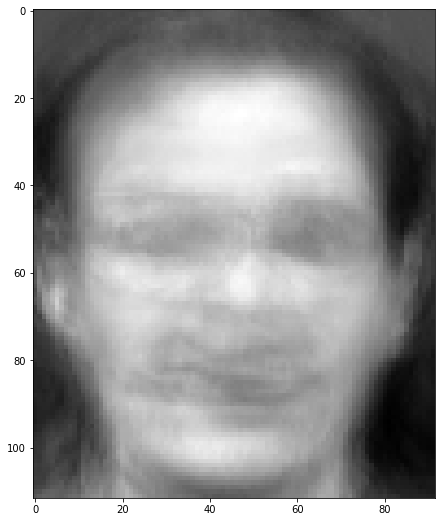

In [38]:
M_ = np.dot(W_ls, H0)
plt.imshow(M_[0].reshape((112,92)), cmap='gray'); plt.show()

And now, the images results by the method used to **minimize g(W,H) using linesearch** (not the alternate method).

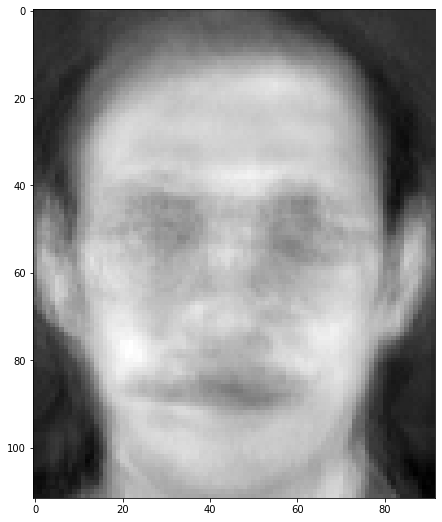

In [35]:
M_ = np.dot(W_1, H_1)
plt.imshow(M_[0].reshape((112,92)), cmap='gray'); plt.show()

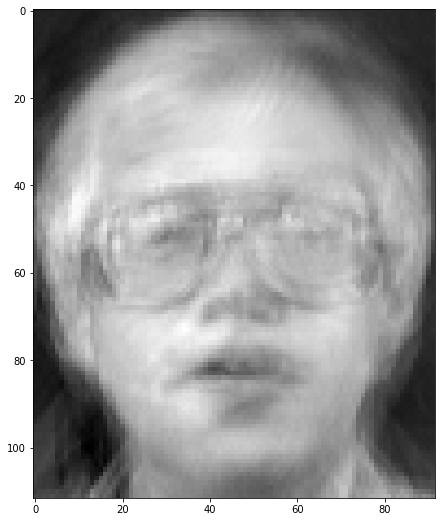

In [36]:
plt.imshow(M_[10].reshape((112,92)), cmap='gray'); plt.show()